In [2]:
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from collections import OrderedDict, Counter
from statistics import mean, stdev

from wordcloud import WordCloud, ImageColorGenerator

%matplotlib inline

In [3]:
"""
Returns the most similar topic in the other period and its similarity score

@param topic_name: topic number to be searched for
@param period_to_cmp: tells which matrix or which periods should be used to find the similarity. It can be either
                     'bf_bf_matrix', 'bf_af_matrix', 'af_bf_matrix', 'af_af_matrix'
@return: the most similar topic name and its value
"""
def get_most_similar_topic(topic_name, period_to_cmp):
    topic_sim_matrix = all_matrix[period_to_cmp]

    if period_to_cmp in ['bf_bf_matrix', 'af_af_matrix']:
        # If this is within the period, the comparison with self should be not included
        matched_topic = np.argmax(np.hstack((topic_sim_matrix[topic_name, :topic_name],
                                             topic_sim_matrix[topic_name, topic_name + 1:])))
    else:
        matched_topic = np.argmax(topic_sim_matrix[topic_name, :])

    return matched_topic, topic_sim_matrix[topic_name, matched_topic]

In [4]:
"""
Returns the distribution value of a particular topic in a given period and its distributions over words.
It also shows WordCloud for those words
"""
def get_topic_info(topic_name, period):
    # dict_keys(['avg', 'topic_sorted_by_dist', 'topic_word_dist_list'])
    result = all_results[period]
    
    dist = result['avg'][topic_name]
    words = [key + ":" + str(round(value, 2)) for key, value in list(result['topic_word_dist_list'][topic_name].items())[:30]]
    words_cnt = {}
    for key, value in list(result['topic_word_dist_list'][topic_name].items())[:100]:
        words_cnt[key] = value*10000

    wc = WordCloud(background_color="white", max_words=1000, max_font_size=90, random_state=42).generate_from_frequencies(words_cnt)
    #image_colors = ImageColorGenerator(mask)
    plt.figure(figsize=[7,7])
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

    return dist, words

In [5]:
"""
This finds possible unique topics given a threshold
"""
def find_unique_topic(matrix_name, threshold=0.7):
    sim_matrix = all_matrix[matrix_name]
    topic_idx = set(range(sim_matrix.shape[0]))
    common_topic_idx = set()
    for i in range(sim_matrix.shape[0]):
        idx = np.where(sim_matrix[i] > threshold)[0]
        #print("scores", sim_matrix[i])
        #print("i", i, "matching score idx", idx)
        if len(idx) > 0:
            common_topic_idx.add(i)

    unique_topic_idx = topic_idx - common_topic_idx

    return list(common_topic_idx), list(unique_topic_idx)

In [6]:
def __compare_sim(topic_sim_matrix, within=False):
    sim_scores = []
    print("shape", topic_sim_matrix.shape)
    for i in range(topic_sim_matrix.shape[0]):
        if within:
            scores = np.hstack((topic_sim_matrix[i, :i], topic_sim_matrix[i, i + 1:]))
        else:
            scores = topic_sim_matrix[i]
        sim_scores.extend(scores)

    mean_sim = mean(sim_scores)
    max_sim = max(sim_scores)

    print("sim scores len", len(sim_scores))
    sns.kdeplot(sim_scores)
    plt.title("Similarity score distribution over all scores on topics")
    plt.show()
    return {"sim_scores": sim_scores, "max_sim": max_sim, "mean_sim": mean_sim,
            "stdev_sim": stdev(sim_scores)}

def __compare_max_sim(topic_sim_matrix, within=False):
    max_sim_scores = []
    for i in range(topic_sim_matrix.shape[0]):
        if within:
            max_score = max(np.hstack((topic_sim_matrix[i, :i], topic_sim_matrix[i, i + 1:])))
        else:
            max_score = max(topic_sim_matrix[i, :])
        max_sim_scores.append(max_score)

    mean_sim = mean(max_sim_scores)
    max_sim = max(max_sim_scores)

    sns.kdeplot(max_sim_scores)
    plt.title("Similarity score distribution over max scores on each topic")
    plt.show()
    return {"max_sim_scores": max_sim_scores, "max_sim": max_sim, "mean_sim": mean_sim,
            "stdev_sim": stdev(max_sim_scores)}

In [7]:
def compare_topics():
    for key, matrix in all_matrix.items():
        within = False
        if key in ['bf_bf_matrix', 'af_af_matrix']:
            within = True
        print("Similarities over all pairs:")
        stats = __compare_sim(matrix, within)
        print(key, '\n')
        print("max", stats['max_sim'], "mean", stats['mean_sim'],
            "stdev", stats["stdev_sim"])
        print("\n")

        print("Max Similarities over each topic:")
        stats = __compare_max_sim(matrix, within)
        print("sim max scores", stats['max_sim_scores'], "max", stats['max_sim'], "mean", stats['mean_sim'],
                "stdev", stats["stdev_sim"])
        print("\n")

In [8]:
"""
The flattened topic, words distribution result and cosine similarity matrix within and between periods are saved in
data/model1/ directory.
"data/model1/distribution/" has the flattened distribution results in bytes which can be just
directly loaded using Pickle library.
"data/model1/matrix/" has the four matrix, each one with 100*100, containing cosine similarities scores.
Please see readme.txt to check which files contains which information.
"""

# loads topic word distribution result from the saved file
all_results = {}
for period in ['bf', 'af']:
    with open('data/model1/distribution/{}_{}.pkl'.format('result', period), 'rb') as f:
        result = pickle.load(f)
        all_results[period] = result
        print(result.keys())

dict_keys(['avg', 'topic_sorted_by_dist', 'topic_word_dist_list'])
dict_keys(['avg', 'topic_sorted_by_dist', 'topic_word_dist_list'])


Similarities over all pairs:
shape (100, 100)
sim scores len 9900


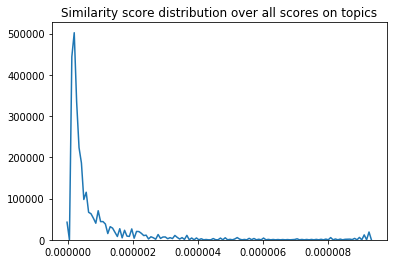

bf_bf_matrix 

max 9.31801911159e-06 mean 1.52799186569e-07 stdev 5.404218633893978e-07


Max Similarities over each topic:


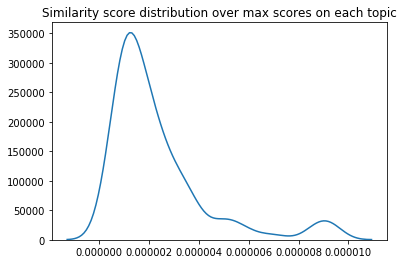

sim max scores [1.8897488487247807e-06, 1.1917879977318207e-06, 8.2423209669791835e-07, 3.0038298581591872e-06, 2.0221442275521847e-06, 3.2947644219932226e-06, 3.0341280344138168e-06, 2.944614315237113e-06, 6.8341317381912694e-07, 9.8630621326827034e-07, 2.7782412094507314e-06, 9.3180191115941309e-06, 3.667795613083486e-06, 3.3517620842371848e-06, 3.562106949103946e-06, 1.3257263014375864e-06, 2.434075502719366e-06, 3.1638374173206928e-06, 1.3586686705626055e-06, 7.8429074394530829e-07, 4.4310627301645556e-07, 5.8753093481942229e-07, 6.0340153286980296e-06, 8.8708829320181877e-07, 1.1635691086765677e-06, 3.0341280344138172e-06, 2.340773860448496e-06, 1.1007110712800538e-06, 2.1199130973119718e-06, 9.6790027902150885e-07, 1.1203932071911539e-06, 5.8464214810729428e-07, 1.4148351834219758e-06, 1.3656538339413925e-06, 1.2643022253776357e-06, 1.355728809592494e-06, 5.2067499151013352e-06, 3.6902640840976792e-07, 1.0228343741671136e-06, 1.5855030439259419e-06, 1.7191331637540881e-06, 2.6314

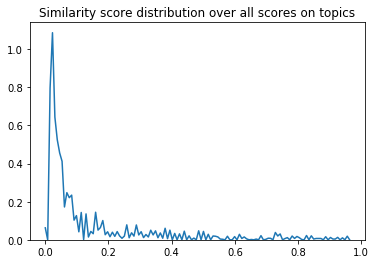

bf_af_matrix 

max 0.963393554271 mean 0.00775662616472 stdev 0.05253237252029141


Max Similarities over each topic:


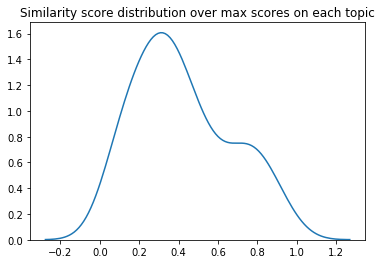

sim max scores [0.54042954312481528, 0.35139621661005394, 0.63294253678888901, 0.18255209029275579, 0.17595092220406652, 0.21655434779318997, 0.18262398294763174, 0.25639236879422783, 0.55002192635338432, 0.76361244617604429, 0.11897649991020674, 0.11485525410634981, 0.21703047229211594, 0.08441149557929567, 0.11074149947524942, 0.57705838338652815, 0.37638598956166802, 0.15844409763900991, 0.41368876974511443, 0.79660572094219873, 0.96339355427135687, 0.78075847612934035, 0.076284378173907499, 0.73004128252659506, 0.39629609940192717, 0.43828455971601082, 0.29037338560242898, 0.68275875205169556, 0.33714605264229353, 0.80328366301814469, 0.37668043379101968, 0.74084339055067172, 0.39594757857461321, 0.90536361127441722, 0.51660381888565621, 0.40878702148900503, 0.080287306358039379, 0.852631782543259, 0.33565328040343556, 0.48274404507884461, 0.3963537442529802, 0.17539571414536698, 0.11489181018322672, 0.84216123585369163, 0.38427378078776675, 0.25987838716201611, 0.28982108143544305

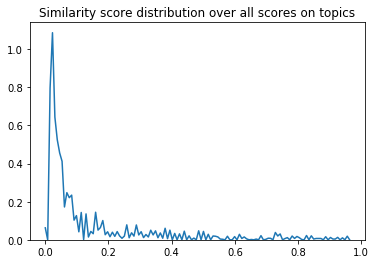

af_bf_matrix 

max 0.963393554271 mean 0.00775662616472 stdev 0.05253237252029141


Max Similarities over each topic:


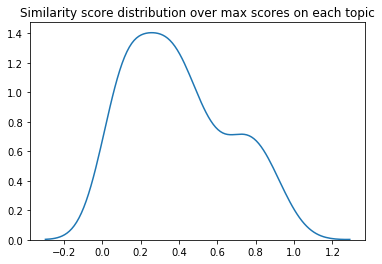

sim max scores [0.25549284188032029, 0.085675346578219652, 0.061140928208892185, 0.42593351581439348, 0.22965954043176209, 0.26759058846907308, 0.15191396069490321, 0.37668043379101968, 0.08441149557929567, 0.39594757857461321, 0.68275875205169556, 0.16903515629546548, 0.48210517133679814, 0.16919828092753247, 0.74245287047758213, 0.07267585742194678, 0.42076352071602985, 0.48643800302460699, 0.35757315746867246, 0.12929971383240285, 0.40878702148900503, 0.25639236879422783, 0.78780976232412891, 0.36082451743953636, 0.39629609940192717, 0.84216123585369163, 0.19063535820313932, 0.058173843510932279, 0.37785514175551693, 0.11291745412731129, 0.48274404507884461, 0.067987991084045546, 0.82668672781209218, 0.14700419670389589, 0.57705838338652815, 0.8676053085430887, 0.11485525410634981, 0.80328366301814469, 0.33565328040343556, 0.73004128252659506, 0.25333924225070825, 0.54042954312481528, 0.2188952365684077, 0.90536361127441722, 0.3301523729699577, 0.49952576052362602, 0.086089484099619

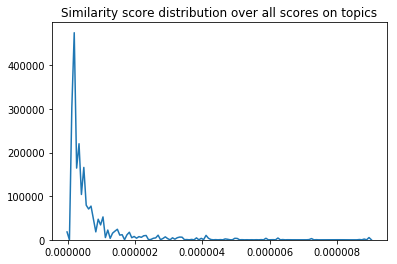

af_af_matrix 

max 9.00581170035e-06 mean 1.07407000528e-07 stdev 4.1057779552290886e-07


Max Similarities over each topic:


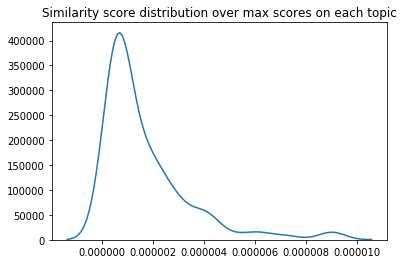

sim max scores [1.7933968815032802e-06, 1.8460845721378603e-06, 4.9882810073557424e-06, 7.7289326698625326e-07, 1.9452493828634588e-06, 6.0618793817680996e-07, 3.4141491602858203e-06, 1.0076027741490986e-06, 3.4171036131355453e-06, 6.9791565651521992e-07, 5.3888317392147125e-07, 4.134332347459147e-06, 3.7350749398130559e-07, 2.6817466615818208e-06, 6.6417716211682287e-07, 1.8650283804391207e-06, 6.3785097404713018e-07, 1.4277574717571203e-06, 6.2680462935107974e-07, 2.5880638332493079e-06, 9.3527083451593131e-07, 1.0755584551531879e-06, 4.6430303415527717e-07, 1.132529647677227e-06, 5.8141656403446525e-07, 9.9365081481280604e-07, 1.5521445569537385e-06, 6.2493406223752913e-06, 9.3610418592969612e-07, 1.8581390170593667e-06, 5.0485440671324739e-07, 5.8785413338412821e-06, 2.6249721883974068e-07, 3.8173445781837989e-06, 9.2391667139013329e-07, 4.6668596972041713e-07, 4.1024426683651678e-06, 6.0423187154098858e-07, 8.1248352304180923e-07, 4.9325611392496415e-07, 1.261975275806421e-06, 7.6

In [9]:
# loads the four cosine similarity matrix. bf represents before and af represents after.
# The name is in a format of row_col_matrix
matrix_file_names = ['bf_bf_matrix','bf_af_matrix', 'af_bf_matrix', 'af_af_matrix']
all_matrix = {}
for key in matrix_file_names:
    matrix = np.load('data/model1/matrix/{}.npy'.format(key))
    all_matrix[key] = matrix

# This shows the distribution density plots over the similarities and the nearest topic similarities
compare_topics()

60 0.252550924593


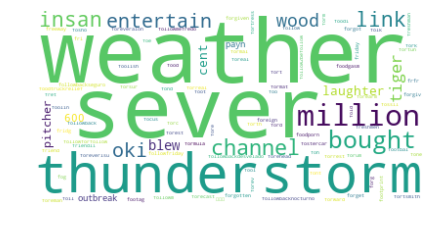

(0.0064508745784572618, ['weather:0.27', 'sever:0.25', 'thunderstorm:0.13', 'million:0.07', 'bought:0.04', 'channel:0.03', 'link:0.03', 'insan:0.03', 'entertain:0.03', 'oki:0.02', 'wood:0.02', 'tiger:0.02', 'blew:0.01', 'cent:0.01', 'laughter:0.01', 'pitcher:0.01', '600:0.01', 'payn:0.0', 'outbreak:0.0', 'fortsmith:0.0', 'forg:0.0', 'forum:0.0', 'foreverlsu:0.0', 'forev:0.0', 'foreveralon:0.0', 'forgiv:0.0', 'forward:0.0', 'forest:0.0', 'foreman:0.0', 'foreign:0.0'])


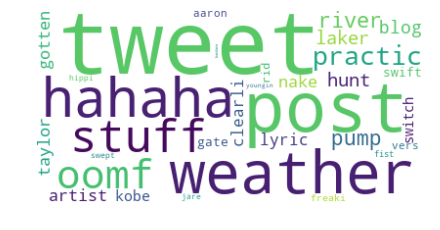

(0.010251861777618101, ['tweet:0.22', 'post:0.12', 'weather:0.12', 'hahaha:0.1', 'stuff:0.08', 'oomf:0.06', 'practic:0.04', 'river:0.02', 'pump:0.02', 'hunt:0.02', 'laker:0.02', 'blog:0.02', 'artist:0.01', 'taylor:0.01', 'gotten:0.01', 'nake:0.01', 'clearli:0.01', 'lyric:0.01', 'kobe:0.01', 'switch:0.01', 'swift:0.01', 'gate:0.01', 'rid:0.01', 'aaron:0.01', 'vers:0.01', 'freaki:0.0', 'fist:0.0', 'swept:0.0', 'hippi:0.0', 'jare:0.0'])


In [10]:
# This find the most similar topic in a particular period when the topic that is interested is given as an input
matched, value = get_most_similar_topic(89, 'af_bf_matrix')
print(matched, value)

# get_topic_info shows WordCloud of this topic. It returns the topic distribution and its corresponding words.
# The period such as 'af' or 'bf' should be given since each period has different result
print(get_topic_info(89, 'af'))
print(get_topic_info(60, 'bf'))

[0, 1, 2, 4, 5, 6, 7, 8, 9, 11, 13, 15, 18, 19, 21, 23, 24, 26, 27, 28, 29, 31, 33, 36, 38, 40, 42, 44, 46, 47, 48, 49, 51, 53, 54, 56, 58, 59, 60, 63, 64, 66, 67, 70, 71, 72, 77, 79, 81, 83, 86, 87, 89, 90, 92, 93, 95, 96, 97]


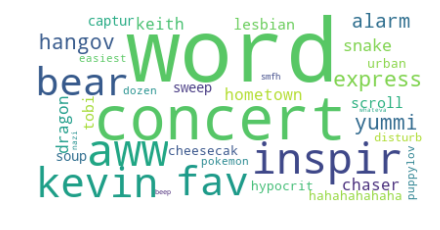

(0.0059838190919566337, ['word:0.3', 'concert:0.11', 'aww:0.06', 'inspir:0.05', 'kevin:0.05', 'fav:0.05', 'bear:0.04', 'express:0.04', 'hangov:0.03', 'yummi:0.03', 'alarm:0.03', 'snake:0.02', 'chaser:0.02', 'dragon:0.02', 'hometown:0.01', 'keith:0.01', 'lesbian:0.01', 'tobi:0.01', 'scroll:0.01', 'soup:0.01', 'captur:0.01', 'sweep:0.01', 'hypocrit:0.01', 'hahahahahaha:0.01', 'urban:0.01', 'cheesecak:0.01', 'disturb:0.01', 'dozen:0.01', 'pokemon:0.01', 'easiest:0.01'])


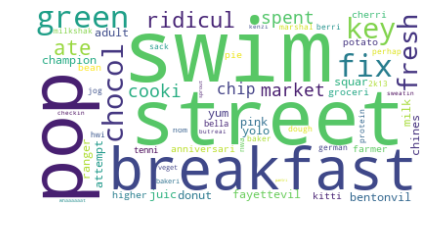

(0.008303215587808362, ['swim:0.07', 'street:0.05', 'pop:0.05', 'breakfast:0.05', 'green:0.05', 'fix:0.05', 'key:0.04', 'chocol:0.03', 'fresh:0.03', 'ridicul:0.03', 'ate:0.03', 'spent:0.03', 'market:0.03', 'cooki:0.03', 'chip:0.02', 'fayettevil:0.02', 'milk:0.02', 'squar:0.02', 'pink:0.02', 'champion:0.02', 'yum:0.02', 'juic:0.02', 'bentonvil:0.02', 'adult:0.02', 'donut:0.02', 'ranger:0.01', 'yolo:0.01', 'chines:0.01', 'attempt:0.01', 'anniversari:0.01'])


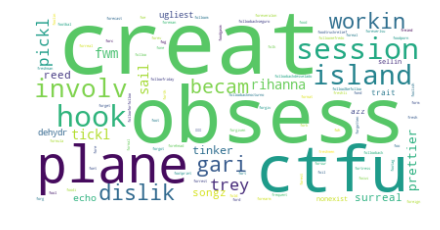

(0.0045918212001810057, ['creat:0.12', 'obsess:0.09', 'ctfu:0.09', 'plane:0.08', 'session:0.07', 'hook:0.07', 'island:0.06', 'involv:0.06', 'gari:0.04', 'dislik:0.04', 'workin:0.04', 'becam:0.03', 'trey:0.02', 'pickl:0.02', 'tickl:0.02', 'fwm:0.02', 'rihanna:0.02', 'sail:0.01', 'prettier:0.01', 'tinker:0.01', 'songz:0.01', 'surreal:0.01', 'reed:0.01', 'echo:0.01', 'dehydr:0.01', 'ugliest:0.01', 'trait:0.01', 'azz:0.01', 'nonexist:0.0', 'sellin:0.0'])


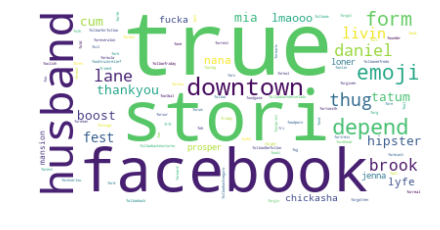

(0.0059150703011103724, ['true:0.28', 'stori:0.16', 'facebook:0.11', 'husband:0.05', 'downtown:0.04', 'depend:0.04', 'emoji:0.03', 'form:0.03', 'thug:0.03', 'lane:0.02', 'daniel:0.02', 'brook:0.02', 'livin:0.02', 'fest:0.01', 'thankyou:0.01', 'mia:0.01', 'cum:0.01', 'hipster:0.01', 'boost:0.01', 'tatum:0.01', 'lmaooo:0.01', 'lyfe:0.01', 'nana:0.01', 'chickasha:0.01', 'fucka:0.01', 'loner:0.01', 'prosper:0.01', 'jenna:0.01', 'mansion:0.0', 'forest:0.0'])


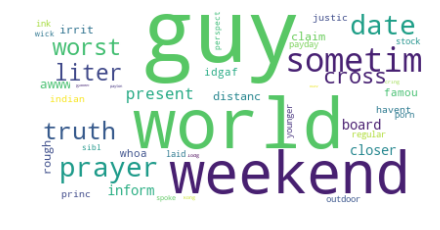

(0.011985641783076475, ['guy:0.23', 'world:0.13', 'weekend:0.1', 'sometim:0.09', 'date:0.06', 'prayer:0.06', 'truth:0.04', 'worst:0.04', 'liter:0.03', 'cross:0.03', 'present:0.02', 'closer:0.01', 'board:0.01', 'inform:0.01', 'awww:0.01', 'claim:0.01', 'rough:0.01', 'distanc:0.01', 'irrit:0.01', 'famou:0.01', 'idgaf:0.01', 'whoa:0.01', 'indian:0.01', 'princ:0.01', 'justic:0.01', 'havent:0.01', 'regular:0.0', 'laid:0.0', 'younger:0.0', 'outdoor:0.0'])


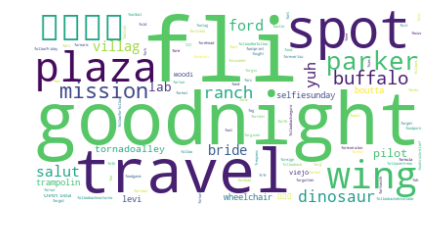

(0.0052504638187736777, ['fli:0.16', 'goodnight:0.13', 'travel:0.11', 'spot:0.1', 'plaza:0.06', 'wing:0.06', 'الله:0.05', 'parker:0.04', 'mission:0.04', 'buffalo:0.03', 'ranch:0.02', 'dinosaur:0.02', 'yuh:0.02', 'salut:0.02', 'ford:0.02', 'villag:0.02', 'bride:0.02', 'lab:0.01', 'pilot:0.01', 'tornadoalley:0.01', 'levi:0.01', 'boutta:0.01', 'trampolin:0.01', 'selfiesunday:0.01', 'wheelchair:0.01', 'شاء:0.0', 'woodi:0.0', 'viejo:0.0', 'oversea:0.0', 'forev:0.0'])


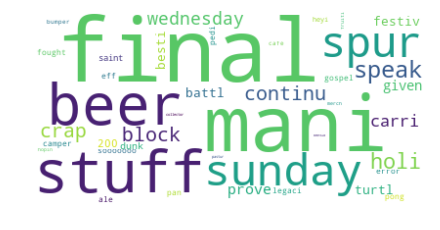

(0.0092569220223298054, ['final:0.18', 'mani:0.14', 'stuff:0.08', 'beer:0.07', 'sunday:0.07', 'spur:0.07', 'speak:0.05', 'holi:0.04', 'continu:0.03', 'block:0.03', 'crap:0.03', 'wednesday:0.03', 'carri:0.02', 'prove:0.02', 'given:0.02', 'festiv:0.02', 'besti:0.01', 'turtl:0.01', 'battl:0.01', '200:0.01', 'dunk:0.01', 'saint:0.01', 'pong:0.01', 'gospel:0.0', 'ale:0.0', 'eff:0.0', 'pan:0.0', 'error:0.0', 'camper:0.0', 'fought:0.0'])


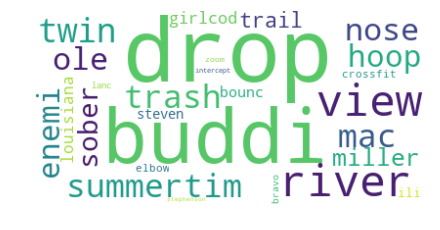

(0.0051452704911639667, ['drop:0.16', 'buddi:0.11', 'river:0.09', 'view:0.09', 'twin:0.05', 'summertim:0.04', 'mac:0.04', 'trash:0.04', 'nose:0.04', 'ole:0.04', 'hoop:0.04', 'enemi:0.04', 'sober:0.03', 'miller:0.03', 'trail:0.02', 'girlcod:0.02', 'louisiana:0.02', 'bounc:0.02', 'steven:0.02', 'ili:0.01', 'crossfit:0.01', 'elbow:0.01', 'bravo:0.01', 'lanc:0.01', 'zoom:0.0', 'intercept:0.0', 'stephenson:0.0', 'forg:0.0', 'foreverlsu:0.0', 'fog:0.0'])


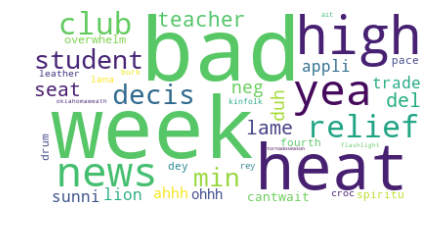

(0.010860602348083392, ['bad:0.2', 'week:0.19', 'heat:0.09', 'high:0.08', 'yea:0.05', 'news:0.05', 'relief:0.04', 'club:0.03', 'decis:0.03', 'student:0.03', 'min:0.02', 'teacher:0.02', 'seat:0.02', 'del:0.02', 'lame:0.02', 'neg:0.01', 'duh:0.01', 'lion:0.01', 'appli:0.01', 'trade:0.01', 'sunni:0.01', 'ahhh:0.01', 'ohhh:0.01', 'cantwait:0.01', 'overwhelm:0.0', 'pace:0.0', 'drum:0.0', 'dey:0.0', 'fourth:0.0', 'spiritu:0.0'])


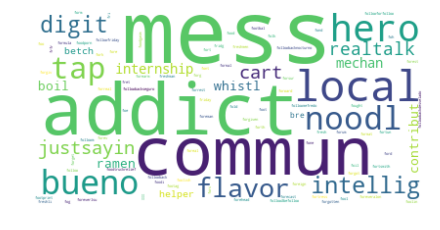

(0.0044746899021565652, ['mess:0.21', 'addict:0.13', 'commun:0.11', 'local:0.08', 'hero:0.06', 'bueno:0.05', 'noodl:0.04', 'tap:0.04', 'flavor:0.03', 'intellig:0.03', 'digit:0.03', 'justsayin:0.02', 'cart:0.02', 'realtalk:0.02', 'internship:0.02', 'mechan:0.02', 'boil:0.01', 'contribut:0.01', 'ramen:0.01', 'whistl:0.01', 'helper:0.01', 'betch:0.01', 'bre:0.0', 'يوم:0.0', 'forev:0.0', 'forest:0.0', 'foreman:0.0', 'foreign:0.0', 'forehead:0.0', 'forecast:0.0'])


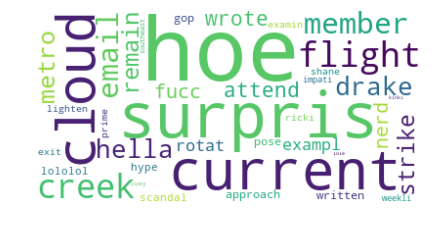

(0.0057217567650494697, ['hoe:0.19', 'surpris:0.08', 'current:0.06', 'cloud:0.06', 'flight:0.05', 'creek:0.05', 'member:0.04', 'email:0.04', 'drake:0.03', 'hella:0.03', 'metro:0.03', 'remain:0.03', 'strike:0.02', 'attend:0.02', 'wrote:0.02', 'fucc:0.02', 'nerd:0.02', 'exampl:0.02', 'rotat:0.02', 'approach:0.02', 'written:0.01', 'pose:0.01', 'gop:0.01', 'hype:0.01', 'scandal:0.01', 'lololol:0.01', 'prime:0.01', 'lighten:0.01', 'exit:0.01', 'shane:0.01'])


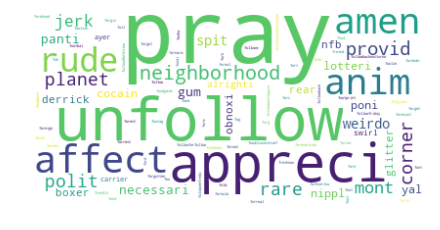

(0.0060566380218560712, ['pray:0.27', 'unfollow:0.1', 'appreci:0.09', 'affect:0.06', 'amen:0.06', 'anim:0.06', 'rude:0.05', 'neighborhood:0.03', 'provid:0.02', 'planet:0.02', 'polit:0.02', 'rare:0.02', 'corner:0.02', 'mont:0.02', 'jerk:0.02', 'spit:0.01', 'weirdo:0.01', 'gum:0.01', 'necessari:0.01', 'panti:0.01', 'yal:0.01', 'cocain:0.01', 'poni:0.01', 'nippl:0.01', 'lotteri:0.01', 'nfb:0.01', 'glitter:0.01', 'derrick:0.01', 'obnoxi:0.01', 'boxer:0.01'])


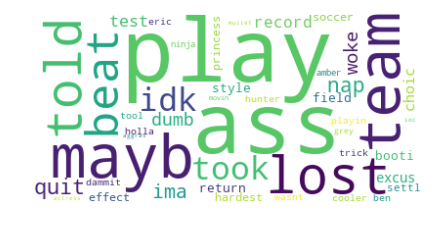

(0.014016564064381093, ['play:0.16', 'ass:0.14', 'mayb:0.06', 'team:0.06', 'lost:0.05', 'told:0.05', 'beat:0.04', 'took:0.04', 'idk:0.04', 'quit:0.03', 'nap:0.03', 'ima:0.03', 'woke:0.03', 'dumb:0.02', 'test:0.02', 'record:0.02', 'choic:0.02', 'excus:0.02', 'field:0.01', 'style:0.01', 'return:0.01', 'booti:0.01', 'princess:0.01', 'soccer:0.01', 'effect:0.01', 'hardest:0.01', 'settl:0.01', 'trick:0.01', 'ben:0.01', 'hunter:0.01'])


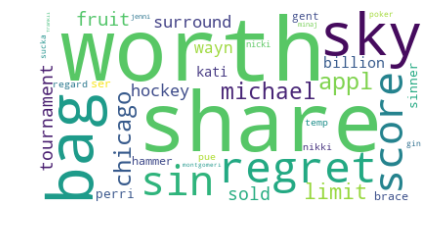

(0.0058380868362185086, ['worth:0.14', 'share:0.12', 'bag:0.06', 'sky:0.06', 'regret:0.06', 'sin:0.05', 'score:0.05', 'appl:0.05', 'chicago:0.05', 'michael:0.04', 'limit:0.04', 'fruit:0.03', 'tournament:0.02', 'sold:0.02', 'surround:0.02', 'hockey:0.02', 'wayn:0.02', 'billion:0.02', 'kati:0.01', 'perri:0.01', 'sinner:0.01', 'brace:0.01', 'ser:0.01', 'hammer:0.01', 'gent:0.01', 'regard:0.01', 'pue:0.01', 'temp:0.01', 'nikki:0.01', 'nicki:0.01'])


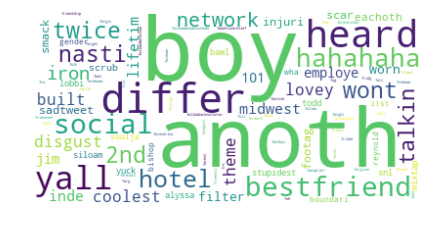

(0.0088785616651552348, ['boy:0.19', 'anoth:0.16', 'differ:0.09', 'heard:0.07', 'yall:0.05', 'bestfriend:0.04', 'social:0.03', 'hahahaha:0.03', 'hotel:0.03', '2nd:0.02', 'nasti:0.02', 'wont:0.02', 'twice:0.02', 'talkin:0.02', 'network:0.02', 'iron:0.01', 'disgust:0.01', 'built:0.01', 'lovey:0.01', 'coolest:0.01', 'theme:0.01', 'inde:0.01', 'midwest:0.01', 'lifetim:0.01', 'employe:0.01', '101:0.01', 'jim:0.01', 'filter:0.01', 'worn:0.01', 'scar:0.01'])


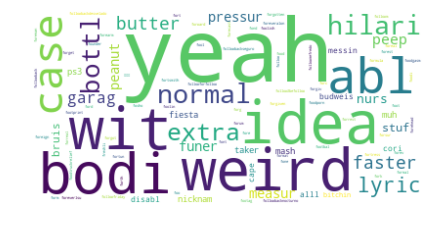

(0.0080775483475503222, ['yeah:0.27', 'idea:0.09', 'weird:0.09', 'wit:0.09', 'bodi:0.08', 'abl:0.06', 'case:0.04', 'hilari:0.03', 'normal:0.03', 'bottl:0.03', 'extra:0.03', 'lyric:0.02', 'faster:0.01', 'butter:0.01', 'garag:0.01', 'peep:0.01', 'peanut:0.01', 'funer:0.01', 'pressur:0.01', 'measur:0.01', 'nurs:0.01', 'stuf:0.01', 'bruis:0.01', 'muh:0.0', 'ps3:0.0', 'fiesta:0.0', 'nicknam:0.0', 'taker:0.0', 'mash:0.0', 'disabl:0.0'])


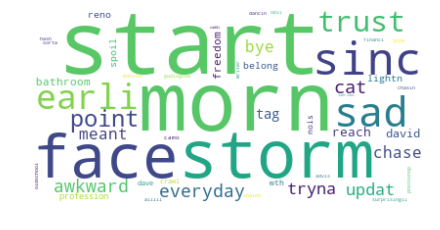

(0.014132224047321255, ['start:0.16', 'morn:0.14', 'storm:0.09', 'face:0.07', 'sinc:0.06', 'sad:0.05', 'earli:0.05', 'trust:0.05', 'point:0.04', 'cat:0.03', 'everyday:0.02', 'awkward:0.02', 'tryna:0.02', 'updat:0.02', 'meant:0.02', 'chase:0.02', 'bye:0.02', 'tag:0.01', 'reach:0.01', 'david:0.01', 'freedom:0.01', 'bathroom:0.01', 'belong:0.01', 'spoil:0.01', 'reno:0.01', 'lightn:0.01', 'profession:0.0', 'wth:0.0', 'nois:0.0', 'dave:0.0'])


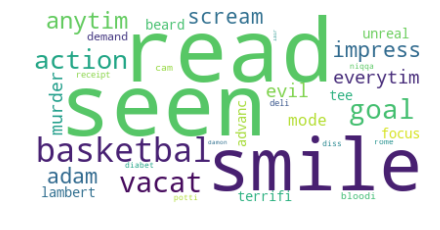

(0.0067779796756315637, ['read:0.17', 'seen:0.16', 'smile:0.14', 'basketbal:0.06', 'vacat:0.05', 'goal:0.04', 'action:0.04', 'anytim:0.03', 'impress:0.03', 'adam:0.03', 'scream:0.03', 'evil:0.02', 'everytim:0.02', 'murder:0.02', 'mode:0.02', 'beard:0.01', 'unreal:0.01', 'advanc:0.01', 'terrifi:0.01', 'lambert:0.01', 'focus:0.01', 'tee:0.01', 'demand:0.01', 'bloodi:0.0', 'cam:0.0', 'receipt:0.0', 'deli:0.0', 'potti:0.0', 'rome:0.0', 'diss:0.0'])


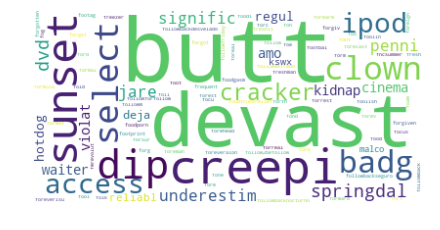

(0.004195263042368373, ['butt:0.17', 'devast:0.11', 'creepi:0.09', 'sunset:0.07', 'dip:0.06', 'select:0.04', 'clown:0.04', 'badg:0.04', 'access:0.03', 'ipod:0.03', 'cracker:0.03', 'springdal:0.03', 'dvd:0.02', 'jare:0.02', 'signific:0.02', 'penni:0.02', 'underestim:0.02', 'kidnap:0.01', 'waiter:0.01', 'violat:0.01', 'cinema:0.01', 'amo:0.01', 'hotdog:0.01', 'regul:0.01', 'deja:0.01', 'reliabl:0.01', 'kswx:0.01', 'malco:0.01', 'ford:0.0', 'fore:0.0'])


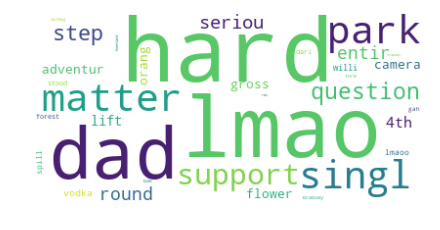

(0.0099400024043055733, ['hard:0.16', 'lmao:0.14', 'dad:0.1', 'park:0.07', 'matter:0.07', 'singl:0.06', 'support:0.06', 'question:0.05', 'step:0.05', 'seriou:0.03', 'round:0.03', 'entir:0.03', '4th:0.02', 'lift:0.02', 'adventur:0.01', 'gross:0.01', 'orang:0.01', 'flower:0.01', 'camera:0.01', 'vodka:0.01', 'willi:0.01', 'lmaoo:0.01', 'spill:0.0', 'stood:0.0', 'darl:0.0', 'forest:0.0', 'gah:0.0', 'bak:0.0', 'tore:0.0', 'bradley:0.0'])


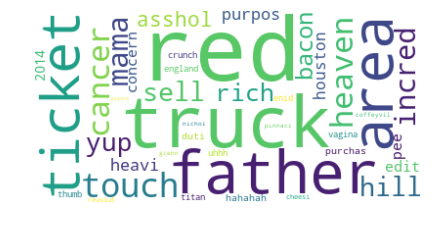

(0.0069997888359215497, ['red:0.13', 'truck:0.08', 'father:0.07', 'area:0.07', 'ticket:0.06', 'touch:0.05', 'cancer:0.04', 'heaven:0.04', 'mama:0.04', 'incred:0.04', 'hill:0.03', 'sell:0.03', 'yup:0.03', 'rich:0.03', 'bacon:0.02', 'asshol:0.02', 'purpos:0.02', 'heavi:0.02', 'houston:0.02', 'pee:0.02', 'edit:0.02', 'concern:0.01', '2014:0.01', 'purchas:0.01', 'hahahah:0.01', 'duti:0.01', 'vagina:0.01', 'thumb:0.01', 'england:0.01', 'uhhh:0.01'])


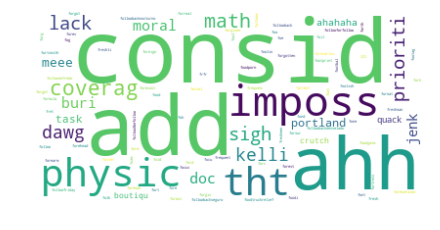

(0.0042717964585311935, ['consid:0.13', 'add:0.11', 'ahh:0.08', 'imposs:0.07', 'physic:0.06', 'tht:0.06', 'coverag:0.06', 'math:0.05', 'lack:0.05', 'prioriti:0.05', 'sigh:0.04', 'kelli:0.04', 'dawg:0.04', 'doc:0.03', 'moral:0.02', 'buri:0.02', 'jenk:0.02', 'meee:0.02', 'portland:0.01', 'task:0.01', 'ahahaha:0.01', 'quack:0.01', 'boutiqu:0.0', 'crutch:0.0', 'forecast:0.0', 'forearm:0.0', 'foreal:0.0', 'forehead:0.0', 'fore:0.0', 'foreign:0.0'])


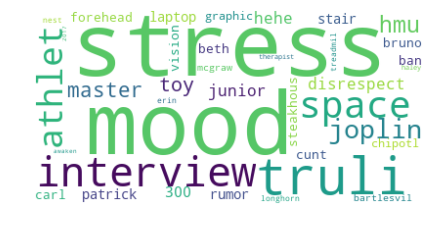

(0.0051209827081578644, ['stress:0.12', 'mood:0.12', 'truli:0.09', 'interview:0.07', 'space:0.06', 'athlet:0.05', 'joplin:0.05', 'hmu:0.04', 'master:0.03', 'toy:0.03', 'disrespect:0.03', 'hehe:0.03', 'junior:0.02', '300:0.02', 'patrick:0.02', 'rumor:0.02', 'laptop:0.02', 'stair:0.02', 'ban:0.01', 'cunt:0.01', 'vision:0.01', 'beth:0.01', 'carl:0.01', 'forehead:0.01', 'steakhous:0.01', 'bruno:0.01', 'chipotl:0.01', 'graphic:0.01', 'bartlesvil:0.01', 'mcgraw:0.01'])


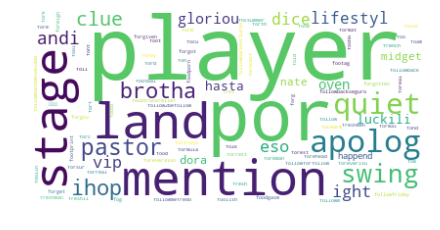

(0.0048100083900018712, ['player:0.16', 'por:0.09', 'mention:0.09', 'land:0.09', 'stage:0.08', 'apolog:0.07', 'quiet:0.06', 'swing:0.04', 'pastor:0.03', 'brotha:0.03', 'ihop:0.03', 'clue:0.03', 'andi:0.02', 'eso:0.02', 'vip:0.02', 'ight:0.02', 'dice:0.01', 'lifestyl:0.01', 'gloriou:0.01', 'oven:0.01', 'luckili:0.01', 'hasta:0.01', 'dora:0.01', 'nate:0.01', 'midget:0.01', 'happend:0.01', 'followfriday:0.0', 'forget:0.0', 'forg:0.0', 'foreverlsu:0.0'])


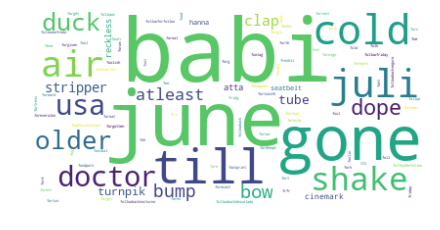

(0.0085010420481986537, ['babi:0.29', 'june:0.2', 'gone:0.12', 'till:0.07', 'cold:0.05', 'juli:0.04', 'air:0.04', 'shake:0.03', 'usa:0.02', 'doctor:0.02', 'older:0.02', 'duck:0.02', 'dope:0.01', 'bow:0.01', 'bump:0.01', 'atleast:0.01', 'clap:0.01', 'stripper:0.01', 'tube:0.0', 'turnpik:0.0', 'reckless:0.0', 'atta:0.0', 'cinemark:0.0', 'hanna:0.0', 'seatbelt:0.0', 'forgot:0.0', 'forev:0.0', 'forehead:0.0', 'foreign:0.0', 'fortun:0.0'])


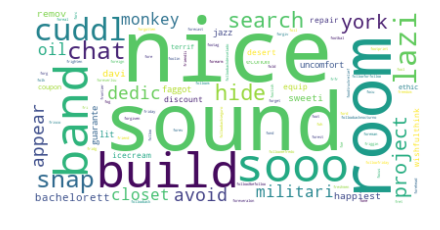

(0.0079970244209991159, ['nice:0.19', 'sound:0.15', 'room:0.11', 'build:0.04', 'sooo:0.04', 'band:0.04', 'cuddl:0.04', 'lazi:0.04', 'snap:0.03', 'chat:0.03', 'hide:0.03', 'search:0.02', 'york:0.02', 'project:0.02', 'avoid:0.02', 'dedic:0.01', 'appear:0.01', 'militari:0.01', 'monkey:0.01', 'closet:0.01', 'oil:0.01', 'bachelorett:0.01', 'davi:0.01', 'happiest:0.01', 'sweeti:0.01', 'remov:0.01', 'jazz:0.01', 'guarante:0.01', 'faggot:0.01', 'uncomfort:0.01'])


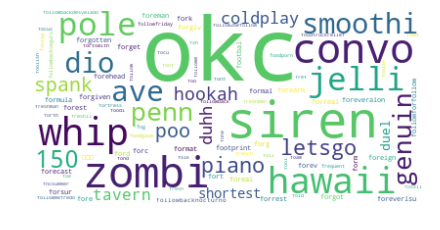

(0.0044951273906979399, ['okc:0.52', 'siren:0.07', 'zombi:0.05', 'convo:0.04', 'whip:0.04', 'hawaii:0.03', 'jelli:0.03', 'pole:0.03', 'ave:0.02', 'smoothi:0.02', 'dio:0.02', 'penn:0.02', 'genuin:0.02', '150:0.01', 'letsgo:0.01', 'piano:0.01', 'spank:0.01', 'poo:0.01', 'hookah:0.01', 'coldplay:0.01', 'duhh:0.01', 'tavern:0.01', 'shortest:0.01', 'duel:0.0', 'forgotten:0.0', 'formula:0.0', 'ford:0.0', 'fort:0.0', 'forsur:0.0', 'fore:0.0'])


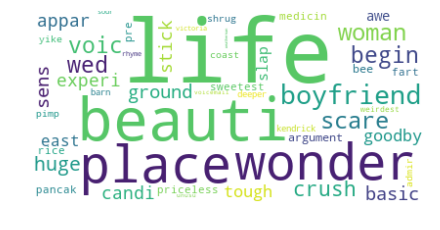

(0.013321356502176567, ['life:0.29', 'beauti:0.1', 'place:0.07', 'wonder:0.07', 'boyfriend:0.04', 'scare:0.03', 'woman:0.03', 'voic:0.03', 'begin:0.03', 'wed:0.03', 'crush:0.02', 'huge:0.02', 'sens:0.02', 'ground:0.02', 'basic:0.02', 'experi:0.02', 'stick:0.02', 'candi:0.01', 'appar:0.01', 'tough:0.01', 'goodby:0.01', 'east:0.01', 'slap:0.01', 'awe:0.01', 'bee:0.01', 'argument:0.01', 'pancak:0.0', 'sweetest:0.0', 'rice:0.0', 'fart:0.0'])


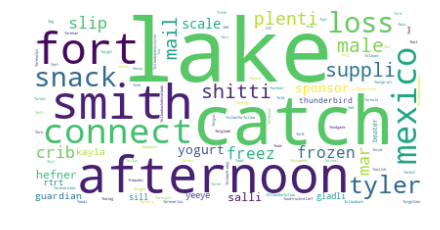

(0.0058286994366893901, ['lake:0.24', 'catch:0.13', 'afternoon:0.06', 'smith:0.06', 'fort:0.05', 'connect:0.04', 'mexico:0.04', 'loss:0.03', 'snack:0.03', 'tyler:0.03', 'suppli:0.03', 'male:0.03', 'shitti:0.02', 'mail:0.02', 'plenti:0.02', 'slip:0.02', 'crib:0.02', 'mar:0.02', 'freez:0.02', 'frozen:0.02', 'scale:0.01', 'yogurt:0.01', 'sponsor:0.01', 'hefner:0.01', 'salli:0.01', 'guardian:0.01', 'kayla:0.01', 'sill:0.0', 'yeeye:0.0', 'gladli:0.0'])


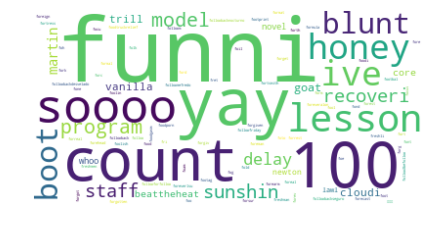

(0.0061294304231073798, ['funni:0.24', 'yay:0.11', '100:0.1', 'count:0.09', 'soooo:0.06', 'lesson:0.05', 'honey:0.04', 'ive:0.04', 'boot:0.03', 'blunt:0.03', 'program:0.03', 'model:0.03', 'staff:0.02', 'sunshin:0.02', 'recoveri:0.02', 'delay:0.02', 'martin:0.01', 'goat:0.01', 'cloudi:0.01', 'trill:0.01', 'vanilla:0.01', 'beattheheat:0.01', 'core:0.01', 'novel:0.0', 'whoo:0.0', 'newton:0.0', 'lawl:0.0', 'forg:0.0', 'foreverlsu:0.0', 'fort:0.0'])


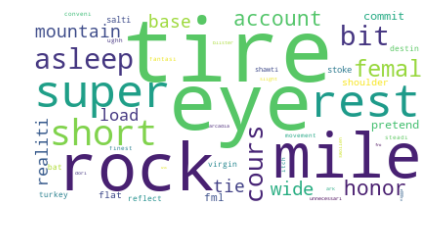

(0.0094423701603495152, ['tire:0.12', 'eye:0.1', 'rock:0.06', 'mile:0.06', 'super:0.05', 'rest:0.05', 'short:0.05', 'asleep:0.05', 'bit:0.05', 'cours:0.04', 'femal:0.04', 'account:0.03', 'honor:0.03', 'wide:0.02', 'tie:0.02', 'mountain:0.02', 'base:0.02', 'realiti:0.02', 'load:0.02', 'pretend:0.02', 'commit:0.01', 'fml:0.01', 'shoulder:0.01', 'flat:0.01', 'salti:0.01', 'stoke:0.01', 'bat:0.01', 'reflect:0.01', 'virgin:0.01', 'destin:0.01'])


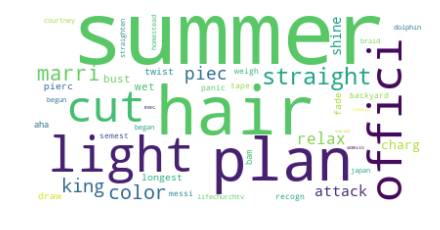

(0.0096342507056268994, ['summer:0.2', 'hair:0.11', 'plan:0.1', 'light:0.06', 'offici:0.06', 'cut:0.05', 'straight:0.05', 'marri:0.04', 'color:0.03', 'king:0.03', 'piec:0.03', 'relax:0.02', 'attack:0.02', 'shine:0.02', 'charg:0.02', 'wet:0.01', 'bust:0.01', 'fade:0.01', 'longest:0.01', 'pierc:0.01', 'draw:0.01', 'twist:0.01', 'aha:0.01', 'bam:0.01', 'tape:0.01', 'backyard:0.01', 'semest:0.01', 'recogn:0.01', 'weigh:0.01', 'messi:0.01'])


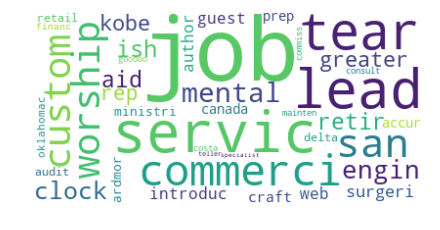

(0.0060538904007797299, ['job:0.27', 'servic:0.08', 'lead:0.07', 'tear:0.06', 'commerci:0.05', 'san:0.04', 'custom:0.03', 'worship:0.03', 'mental:0.03', 'engin:0.02', 'clock:0.02', 'ish:0.02', 'aid:0.02', 'retir:0.02', 'greater:0.02', 'kobe:0.02', 'rep:0.02', 'surgeri:0.02', 'introduc:0.01', 'web:0.01', 'author:0.01', 'guest:0.01', 'craft:0.01', 'prep:0.01', 'canada:0.01', 'accur:0.01', 'ministri:0.01', 'ardmor:0.01', 'retail:0.01', 'delta:0.01'])


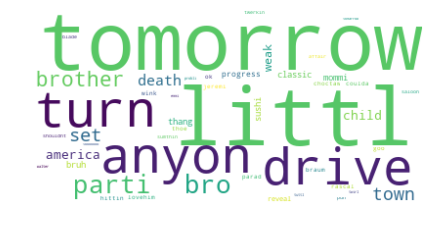

(0.013823180953089183, ['tomorrow:0.15', 'littl:0.15', 'anyon:0.08', 'drive:0.08', 'turn:0.08', 'parti:0.08', 'bro:0.08', 'brother:0.05', 'set:0.04', 'town:0.04', 'death:0.02', 'child:0.02', 'america:0.02', 'weak:0.02', 'bruh:0.01', 'mommi:0.01', 'classic:0.01', 'sushi:0.01', 'thang:0.01', 'progress:0.01', 'reveal:0.0', 'lovehim:0.0', 'ok:0.0', 'parad:0.0', 'thoe:0.0', 'choctaw:0.0', 'wink:0.0', 'rascal:0.0', 'hittin:0.0', 'braum:0.0'])


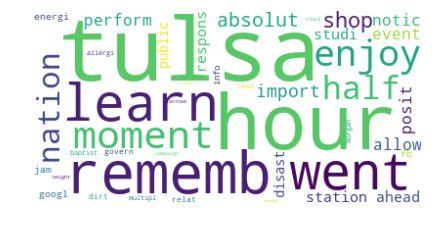

(0.012693622894123926, ['tulsa:0.16', 'hour:0.12', 'rememb:0.08', 'learn:0.06', 'went:0.06', 'moment:0.05', 'enjoy:0.05', 'half:0.04', 'nation:0.03', 'shop:0.03', 'absolut:0.03', 'import:0.02', 'posit:0.02', 'perform:0.02', 'notic:0.02', 'event:0.02', 'allow:0.02', 'station:0.01', 'respons:0.01', 'studi:0.01', 'ahead:0.01', 'public:0.01', 'disast:0.01', 'energi:0.01', 'jam:0.01', 'fb:0.01', 'googl:0.01', 'info:0.01', 'dirt:0.01', 'relat:0.01'])


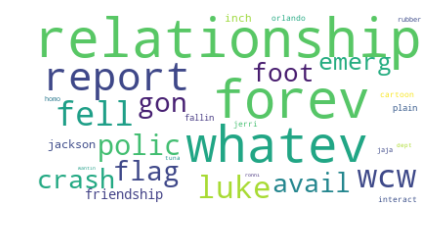

(0.0062117317842650165, ['relationship:0.15', 'forev:0.14', 'whatev:0.12', 'report:0.08', 'fell:0.05', 'wcw:0.05', 'luke:0.04', 'polic:0.04', 'flag:0.03', 'gon:0.03', 'crash:0.03', 'avail:0.03', 'foot:0.03', 'emerg:0.03', 'friendship:0.03', 'jackson:0.02', 'inch:0.02', 'plain:0.01', 'fallin:0.01', 'jerri:0.01', 'orlando:0.01', 'interact:0.01', 'cartoon:0.01', 'jaja:0.01', 'rubber:0.01', 'homo:0.01', 'dept:0.0', 'tuna:0.0', 'ronni:0.0', 'wantin:0.0'])


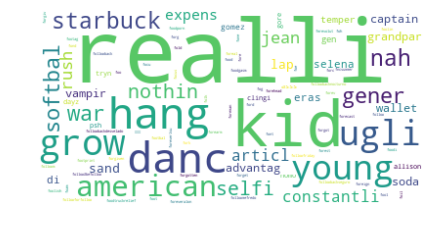

(0.011154886502239536, ['realli:0.36', 'kid:0.15', 'hang:0.06', 'danc:0.06', 'grow:0.04', 'young:0.03', 'ugli:0.03', 'american:0.03', 'starbuck:0.02', 'nah:0.02', 'war:0.02', 'softbal:0.02', 'gener:0.02', 'selfi:0.02', 'nothin:0.01', 'jean:0.01', 'rush:0.01', 'constantli:0.01', 'articl:0.01', 'expens:0.01', 'sand:0.01', 'lap:0.01', 'soda:0.0', 'captain:0.0', 'wallet:0.0', 'advantag:0.0', 'grandpar:0.0', 'vampir:0.0', 'di:0.0', 'eras:0.0'])


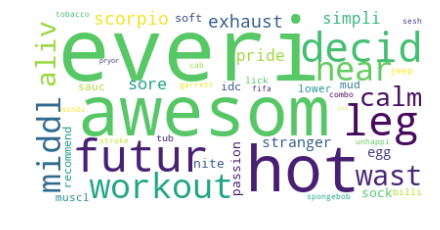

(0.0096804478010175336, ['everi:0.22', 'awesom:0.13', 'hot:0.11', 'futur:0.04', 'leg:0.04', 'decid:0.04', 'workout:0.04', 'near:0.03', 'middl:0.03', 'wast:0.03', 'aliv:0.03', 'calm:0.02', 'scorpio:0.02', 'exhaust:0.02', 'sore:0.02', 'simpli:0.01', 'pride:0.01', 'stranger:0.01', 'egg:0.01', 'nite:0.01', 'passion:0.01', 'sock:0.01', 'idc:0.01', 'recommend:0.01', 'soft:0.01', 'mud:0.01', 'sauc:0.01', 'lower:0.01', 'muscl:0.01', 'lick:0.01'])


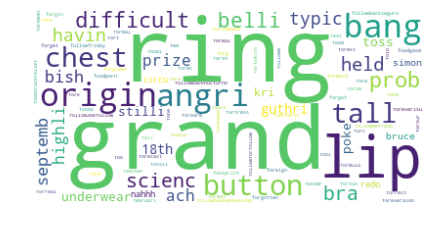

(0.0049140266838592298, ['ring:0.09', 'grand:0.09', 'lip:0.08', 'origin:0.05', 'bang:0.05', 'angri:0.05', 'button:0.04', 'tall:0.04', 'chest:0.04', 'difficult:0.04', 'prob:0.04', 'belli:0.03', 'scienc:0.03', 'bra:0.03', 'held:0.03', 'typic:0.02', 'havin:0.02', 'septemb:0.02', 'bish:0.02', 'prize:0.02', 'highli:0.02', 'ach:0.02', 'guthri:0.02', '18th:0.02', 'underwear:0.01', 'toss:0.01', 'stilli:0.01', 'poke:0.01', 'kri:0.01', 'simon:0.01'])


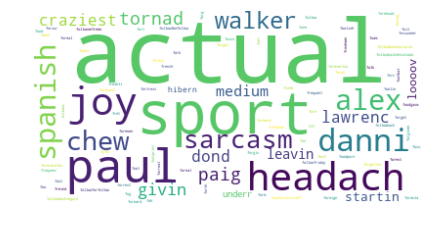

(0.0049381177290916088, ['actual:0.4', 'sport:0.14', 'paul:0.08', 'joy:0.06', 'headach:0.05', 'danni:0.04', 'spanish:0.03', 'alex:0.03', 'chew:0.03', 'sarcasm:0.02', 'walker:0.02', 'tornad:0.01', 'paig:0.01', 'givin:0.01', 'dond:0.01', 'lawrenc:0.01', 'craziest:0.01', 'medium:0.01', 'leavin:0.01', 'startin:0.01', 'loooov:0.01', 'underr:0.0', 'hibern:0.0', 'forgiven:0.0', 'forsur:0.0', 'forc:0.0', 'ford:0.0', 'forrest:0.0', 'forreal:0.0', 'formula:0.0'])


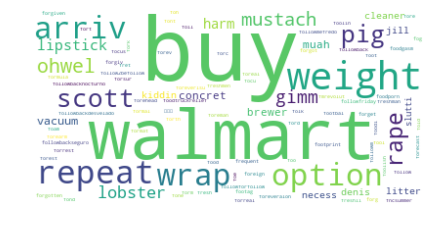

(0.004698693796658957, ['buy:0.3', 'walmart:0.17', 'weight:0.09', 'repeat:0.06', 'arriv:0.05', 'wrap:0.05', 'option:0.05', 'scott:0.03', 'pig:0.03', 'rape:0.03', 'ohwel:0.02', 'mustach:0.02', 'gimm:0.02', 'lobster:0.01', 'lipstick:0.01', 'harm:0.01', 'vacuum:0.01', 'concret:0.01', 'brewer:0.01', 'muah:0.01', 'necess:0.0', 'kiddin:0.0', 'litter:0.0', 'denis:0.0', 'cleaner:0.0', 'jill:0.0', 'slutti:0.0', 'foreign:0.0', 'focu:0.0', 'foreveralon:0.0'])


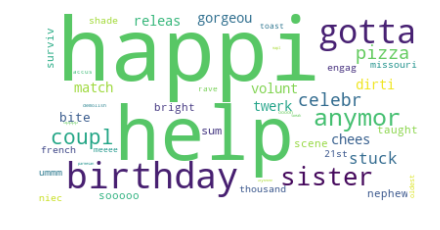

(0.013450473103095261, ['happi:0.22', 'help:0.15', 'birthday:0.11', 'gotta:0.09', 'sister:0.05', 'anymor:0.04', 'coupl:0.03', 'pizza:0.02', 'celebr:0.02', 'stuck:0.02', 'gorgeou:0.01', 'volunt:0.01', 'dirti:0.01', 'chees:0.01', 'twerk:0.01', 'releas:0.01', 'match:0.01', 'bite:0.01', 'sum:0.01', 'nephew:0.01', 'surviv:0.01', 'bright:0.01', 'sooooo:0.01', 'scene:0.01', 'taught:0.01', 'thousand:0.01', 'french:0.01', 'niec:0.01', 'engag:0.01', '21st:0.01'])


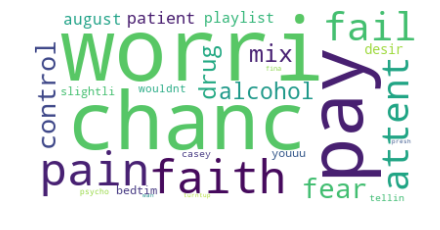

(0.0065251655090365224, ['worri:0.14', 'chanc:0.11', 'pay:0.1', 'pain:0.09', 'faith:0.08', 'fail:0.06', 'attent:0.05', 'fear:0.05', 'control:0.05', 'mix:0.04', 'drug:0.04', 'alcohol:0.03', 'patient:0.02', 'august:0.02', 'playlist:0.02', 'desir:0.02', 'youuu:0.01', 'bedtim:0.01', 'slightli:0.01', 'wouldnt:0.01', 'casey:0.01', 'tellin:0.01', 'psycho:0.0', 'fina:0.0', 'presh:0.0', 'turntup:0.0', 'wan:0.0', 'forgiven:0.0', 'forreal:0.0', 'fortress:0.0'])


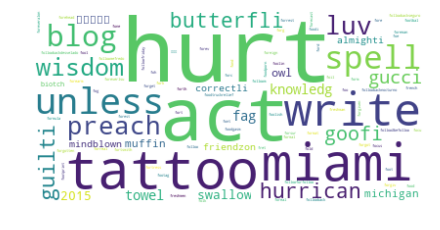

(0.0059812255401894719, ['hurt:0.25', 'act:0.16', 'tattoo:0.08', 'miami:0.07', 'write:0.06', 'unless:0.06', 'spell:0.04', 'blog:0.03', 'preach:0.02', 'luv:0.02', 'wisdom:0.02', 'guilti:0.02', 'hurrican:0.01', 'butterfli:0.01', 'goofi:0.01', 'gucci:0.01', 'knowledg:0.01', 'towel:0.01', 'fag:0.01', '2015:0.01', 'swallow:0.01', 'owl:0.01', 'michigan:0.01', 'muffin:0.01', 'والله:0.01', 'correctli:0.01', 'friendzon:0.0', 'almighti:0.0', 'mindblown:0.0', 'biotch:0.0'])


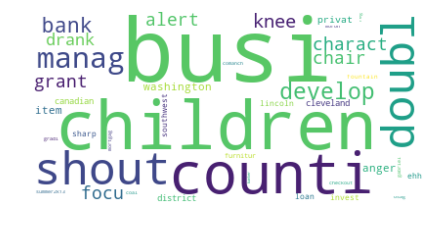

(0.0056374089068311397, ['busi:0.16', 'children:0.09', 'counti:0.07', 'shout:0.06', 'doubl:0.06', 'manag:0.05', 'develop:0.05', 'bank:0.04', 'knee:0.03', 'focu:0.03', 'alert:0.03', 'grant:0.03', 'charact:0.03', 'chair:0.03', 'drank:0.02', 'washington:0.02', 'anger:0.02', 'item:0.02', 'privat:0.02', 'cleveland:0.01', 'district:0.01', 'canadian:0.01', 'lincoln:0.01', 'sharp:0.01', 'invest:0.01', 'loan:0.01', 'southwest:0.01', 'ehh:0.01', 'furnitur:0.01', 'fountain:0.01'])


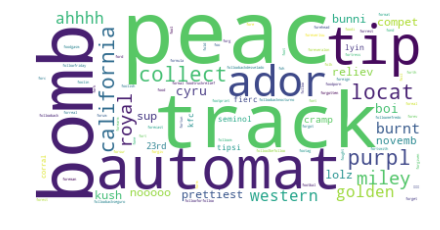

(0.0051279557437698166, ['peac:0.1', 'track:0.07', 'bomb:0.07', 'automat:0.07', 'tip:0.06', 'ador:0.06', 'collect:0.05', 'purpl:0.05', 'locat:0.04', 'california:0.04', 'miley:0.03', 'royal:0.03', 'western:0.03', 'ahhhh:0.03', 'golden:0.03', 'burnt:0.03', 'cyru:0.02', 'boi:0.02', 'bunni:0.02', 'sup:0.01', 'kush:0.01', 'nooooo:0.01', 'reliev:0.01', 'prettiest:0.01', 'compet:0.01', 'lolz:0.01', 'novemb:0.01', 'cramp:0.01', '23rd:0.01', 'fierc:0.01'])


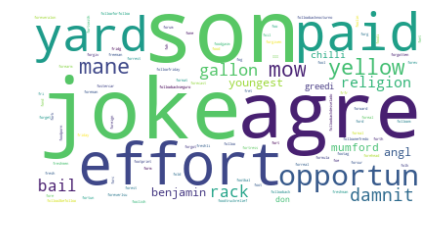

(0.004953833198065226, ['son:0.18', 'joke:0.17', 'agre:0.15', 'effort:0.09', 'paid:0.07', 'yard:0.06', 'opportun:0.06', 'yellow:0.03', 'mane:0.03', 'mow:0.02', 'damnit:0.02', 'gallon:0.02', 'bail:0.01', 'rack:0.01', 'religion:0.01', 'youngest:0.01', 'angl:0.01', 'benjamin:0.01', 'mumford:0.01', 'chilli:0.01', 'greedi:0.0', 'don:0.0', 'forecast:0.0', 'forearm:0.0', 'foreman:0.0', 'forehead:0.0', 'forest:0.0', 'foreign:0.0', 'foreal:0.0', 'foreverlsu:0.0'])


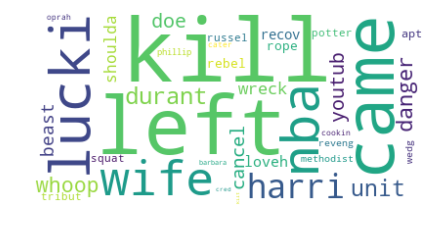

(0.0067660359286290288, ['kill:0.19', 'left:0.15', 'came:0.11', 'lucki:0.07', 'nba:0.06', 'wife:0.05', 'harri:0.04', 'durant:0.03', 'unit:0.03', 'danger:0.03', 'whoop:0.02', 'doe:0.02', 'youtub:0.02', 'cancel:0.02', 'beast:0.02', 'wreck:0.02', 'shoulda:0.01', 'loveh:0.01', 'recov:0.01', 'rebel:0.01', 'rope:0.01', 'apt:0.01', 'potter:0.01', 'squat:0.01', 'russel:0.01', 'tribut:0.01', 'reveng:0.01', 'wedg:0.0', 'methodist:0.0', 'phillip:0.0'])


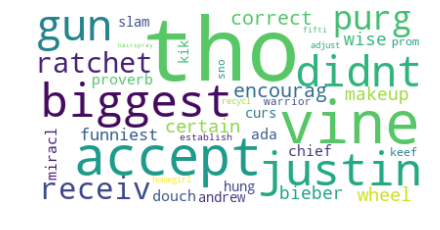

(0.0068282704284211978, ['tho:0.23', 'vine:0.08', 'accept:0.06', 'biggest:0.04', 'justin:0.04', 'didnt:0.04', 'gun:0.04', 'purg:0.04', 'receiv:0.04', 'ratchet:0.03', 'encourag:0.03', 'correct:0.03', 'wheel:0.02', 'certain:0.02', 'bieber:0.02', 'wise:0.02', 'makeup:0.02', 'funniest:0.02', 'chief:0.01', 'douch:0.01', 'miracl:0.01', 'proverb:0.01', 'ada:0.01', 'kik:0.01', 'slam:0.01', 'curs:0.01', 'hung:0.01', 'andrew:0.01', 'prom:0.01', 'keef:0.01'])


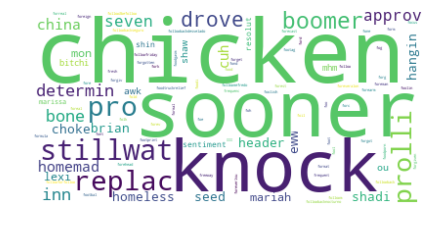

(0.005150936552869881, ['chicken:0.12', 'sooner:0.1', 'knock:0.08', 'stillwat:0.05', 'replac:0.05', 'pro:0.05', 'prolli:0.04', 'boomer:0.04', 'drove:0.04', 'determin:0.03', 'bone:0.03', 'inn:0.03', 'approv:0.03', 'seven:0.03', 'homemad:0.02', 'china:0.02', 'cuh:0.02', 'header:0.02', 'choke:0.02', 'shadi:0.02', 'brian:0.02', 'seed:0.02', 'eww:0.02', 'homeless:0.02', 'hangin:0.01', 'mariah:0.01', 'lexi:0.01', 'mon:0.01', 'ou:0.01', 'awk:0.01'])


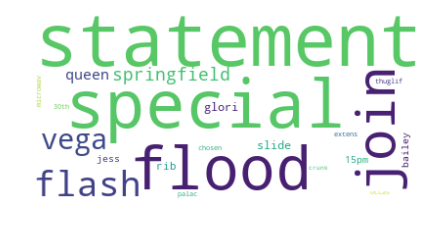

(0.0052904644343880055, ['statement:0.22', 'special:0.18', 'flood:0.14', 'join:0.11', 'flash:0.08', 'vega:0.05', 'springfield:0.05', 'queen:0.03', 'glori:0.02', 'slide:0.02', 'rib:0.02', 'bailey:0.01', '15pm:0.01', 'jess:0.01', '30th:0.01', 'microwav:0.01', 'chosen:0.01', 'extens:0.01', 'occas:0.0', 'palac:0.0', 'thuglif:0.0', 'crunk:0.0', 'foreign:0.0', 'foreman:0.0', 'يوم:0.0', 'foreal:0.0', 'forehead:0.0', 'forecast:0.0', 'forearm:0.0', 'forev:0.0'])


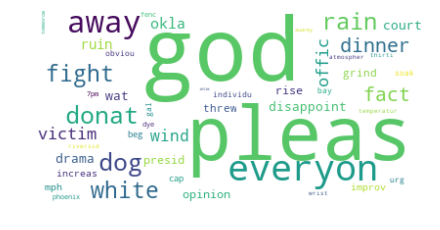

(0.014146482643716955, ['god:0.17', 'pleas:0.12', 'everyon:0.11', 'away:0.08', 'donat:0.05', 'dog:0.05', 'rain:0.04', 'fight:0.04', 'white:0.04', 'dinner:0.03', 'fact:0.03', 'victim:0.02', 'offic:0.02', 'wind:0.02', 'okla:0.02', 'ruin:0.01', 'drama:0.01', 'wat:0.01', 'disappoint:0.01', 'court:0.01', 'rise:0.01', 'opinion:0.01', 'presid:0.01', 'grind:0.01', 'threw:0.01', 'improv:0.01', 'mph:0.01', 'increas:0.0', 'cap:0.0', 'beg:0.0'])


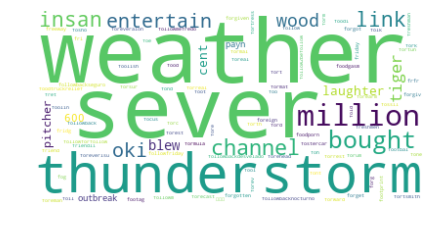

(0.0064508745784572618, ['weather:0.27', 'sever:0.25', 'thunderstorm:0.13', 'million:0.07', 'bought:0.04', 'channel:0.03', 'link:0.03', 'insan:0.03', 'entertain:0.03', 'oki:0.02', 'wood:0.02', 'tiger:0.02', 'blew:0.01', 'cent:0.01', 'laughter:0.01', 'pitcher:0.01', '600:0.01', 'payn:0.0', 'outbreak:0.0', 'fortsmith:0.0', 'forg:0.0', 'forum:0.0', 'foreverlsu:0.0', 'forev:0.0', 'foreveralon:0.0', 'forgiv:0.0', 'forward:0.0', 'forest:0.0', 'foreman:0.0', 'foreign:0.0'])


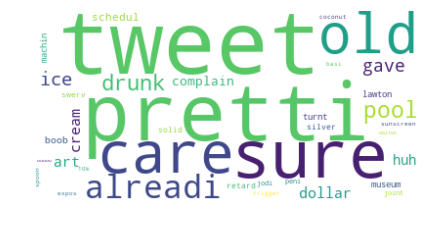

(0.013798331171467757, ['tweet:0.14', 'pretti:0.12', 'sure:0.12', 'care:0.11', 'old:0.11', 'alreadi:0.1', 'pool:0.04', 'drunk:0.04', 'ice:0.03', 'gave:0.03', 'art:0.02', 'dollar:0.02', 'cream:0.02', 'huh:0.02', 'complain:0.01', 'schedul:0.01', 'boob:0.01', 'lawton:0.01', 'museum:0.01', 'machin:0.01', 'turnt:0.01', 'retard:0.01', 'solid:0.0', 'swerv:0.0', 'silver:0.0', 'joint:0.0', 'jodi:0.0', 'peni:0.0', 'basi:0.0', 'expos:0.0'])


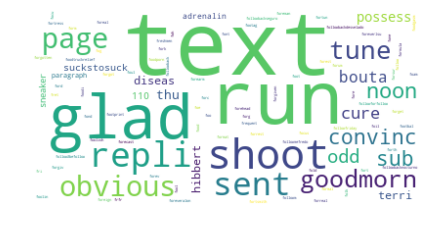

(0.0082990331436651014, ['text:0.33', 'run:0.22', 'glad:0.14', 'shoot:0.05', 'repli:0.04', 'sent:0.03', 'obvious:0.02', 'page:0.02', 'tune:0.02', 'goodmorn:0.02', 'noon:0.01', 'sub:0.01', 'convinc:0.01', 'odd:0.01', 'cure:0.01', 'bouta:0.01', 'possess:0.01', 'thu:0.0', 'diseas:0.0', 'terri:0.0', 'hibbert:0.0', '110:0.0', 'suckstosuck:0.0', 'sneaker:0.0', 'adrenalin:0.0', 'paragraph:0.0', 'followfriday:0.0', 'foreveralon:0.0', 'forgiven:0.0', 'forgiv:0.0'])


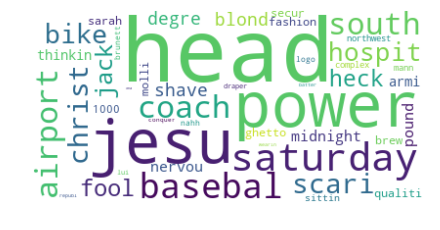

(0.0088883410317689374, ['head:0.19', 'power:0.08', 'jesu:0.07', 'saturday:0.07', 'basebal:0.05', 'airport:0.04', 'coach:0.04', 'south:0.04', 'scari:0.03', 'christ:0.03', 'bike:0.03', 'hospit:0.03', 'fool:0.02', 'jack:0.02', 'heck:0.02', 'degre:0.02', 'blond:0.02', 'shave:0.02', 'midnight:0.02', 'nervou:0.02', 'pound:0.01', 'thinkin:0.01', 'armi:0.01', 'qualiti:0.01', 'brew:0.01', 'secur:0.01', 'fashion:0.01', 'molli:0.01', 'ghetto:0.01', 'sarah:0.01'])


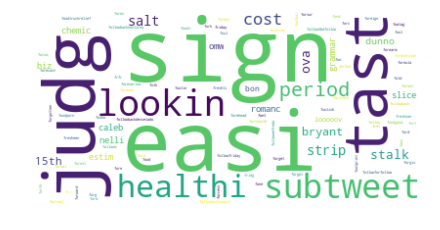

(0.0052119536316274995, ['sign:0.18', 'easi:0.15', 'judg:0.11', 'tast:0.08', 'lookin:0.07', 'subtweet:0.06', 'healthi:0.05', 'period:0.05', 'cost:0.03', 'salt:0.02', 'strip:0.02', 'stalk:0.02', 'ova:0.02', 'bryant:0.02', '15th:0.01', 'dunno:0.01', 'grammar:0.01', 'slice:0.01', 'romanc:0.01', 'estim:0.01', 'caleb:0.01', 'omw:0.01', 'nelli:0.01', 'biz:0.01', 'chemic:0.01', 'bon:0.01', 'looooov:0.0', 'forgiv:0.0', 'forgotten:0.0', 'forgot:0.0'])


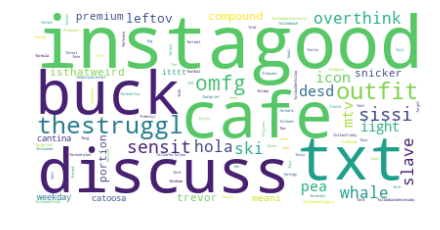

(0.0040999977030739612, ['instagood:0.1', 'cafe:0.08', 'discuss:0.07', 'buck:0.07', 'txt:0.07', 'thestruggl:0.06', 'outfit:0.06', 'omfg:0.05', 'sissi:0.04', 'sensit:0.03', 'ski:0.03', 'whale:0.03', 'slave:0.03', 'overthink:0.03', 'hola:0.03', 'icon:0.02', 'mtv:0.02', 'pea:0.02', 'desd:0.02', 'iight:0.02', 'leftov:0.02', 'compound:0.01', 'premium:0.01', 'trevor:0.01', 'isthatweird:0.01', 'snicker:0.01', 'portion:0.01', 'meani:0.01', 'cantina:0.01', 'catoosa:0.01'])


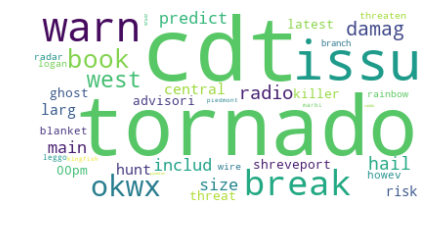

(0.012631823838555298, ['cdt:0.24', 'tornado:0.21', 'issu:0.14', 'warn:0.08', 'break:0.06', 'okwx:0.04', 'book:0.03', 'west:0.02', 'damag:0.02', 'radio:0.01', 'hail:0.01', 'size:0.01', 'main:0.01', 'includ:0.01', 'predict:0.01', 'central:0.01', 'larg:0.01', 'hunt:0.01', 'risk:0.01', 'shreveport:0.01', 'advisori:0.01', '00pm:0.01', 'killer:0.01', 'latest:0.01', 'ghost:0.0', 'threat:0.0', 'howev:0.0', 'blanket:0.0', 'rainbow:0.0', 'wire:0.0'])


In [11]:
# This finds the unique topic given the period and the threshold. It returns the unique topics of a particular row.
unique_af_topics = find_unique_topic('af_bf_matrix', 0.4)[1]
print(unique_af_topics)

# This will iterate unique topic found and shows the WordCloud for each topic
for topic in unique_af_topics:
    print(get_topic_info(topic, 'af'))